# Import the data and necessary libraries

In [1875]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [1876]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 

In [1877]:
home_equity = pd.read_excel(r"C:\Users\Nastya\Desktop\Home_Eq_Dataset.xlsx")
home_equity.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [1878]:
home_equity.columns.values

array(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'], dtype=object)

In [1879]:
home_equity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5432 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


### Drop missing values;  Check the distribution of Good and Bad

In [1880]:
home_equity = home_equity.dropna()

In [1881]:
home_equity['BAD'] = home_equity['BAD'].replace({0: 1, 1: 0})

In [1882]:
# check the observed default rate
counts = home_equity['BAD'].value_counts()
proportions_b_g = counts/counts.sum()
print(proportions_b_g)

1    0.91082
0    0.08918
Name: BAD, dtype: float64


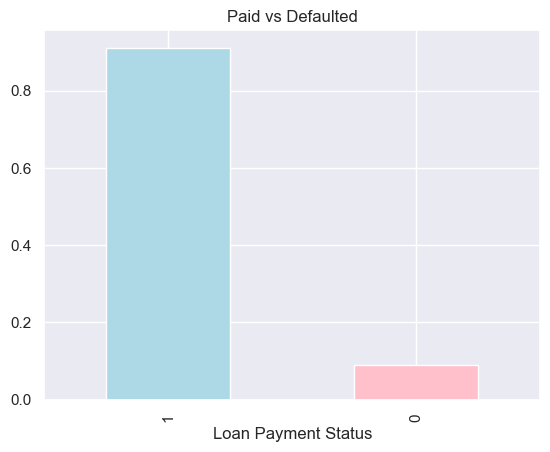

In [1883]:
fig, ax = plt.subplots()
ax = proportions_b_g.plot(kind='bar', color=['lightblue', 'pink'])
ax.set_xlabel('Loan Payment Status')
ax.set_title('Paid vs Defaulted')
plt.show()


# Binning the categorical data
# Woe and IV calculation


In [1884]:
print(home_equity['JOB'].unique())

['Other' 'Office' 'Mgr' 'ProfExe' 'Sales' 'Self']


In [1885]:
print(home_equity['REASON'].unique())

['HomeImp' 'DebtCon']


In [1886]:
prop_by_reason = home_equity.groupby('REASON')['BAD'].mean()
prop_by_reason

REASON
DebtCon    0.909667
HomeImp    0.913568
Name: BAD, dtype: float64

In [1887]:
prop_by_job = home_equity.groupby('JOB')['BAD'].mean()
prop_by_job

JOB
Mgr        0.900000
Office     0.934142
Other      0.897356
ProfExe    0.935484
Sales      0.735849
Self       0.868687
Name: BAD, dtype: float64

In [1888]:
grouped_df = home_equity.groupby('JOB')['BAD'].agg(['count', 'mean'])
grouped_df = grouped_df.reset_index()
grouped_df

,JOB,count,mean
0,Mgr,450,0.900000
1,Office,577,0.934142
2,Other,1286,0.897356
3,ProfExe,899,0.935484
4,Sales,53,0.735849
5,Self,99,0.868687


In [1889]:
col_name = grouped_df.columns.values[0]
print(col_name)

JOB


In [1890]:
grouped_df.columns = [grouped_df.columns.values[0], 'n_obs', 'prop_good']
grouped_df

,JOB,n_obs,prop_good
0,Mgr,450,0.900000
1,Office,577,0.934142
2,Other,1286,0.897356
3,ProfExe,899,0.935484
4,Sales,53,0.735849
5,Self,99,0.868687


In [1891]:
grouped_df['prop_n_obs'] = grouped_df['n_obs'] / grouped_df['n_obs'].sum()
grouped_df['n_good'] = grouped_df['prop_good'] * grouped_df['n_obs'] #calculates with respective grade
grouped_df['n_bad'] = (1 - grouped_df['prop_good']) * grouped_df['n_obs']
grouped_df['prop_n_good'] = grouped_df['n_good'] / grouped_df['n_good'].sum()
grouped_df['prop_n_bad'] = grouped_df['n_bad'] / grouped_df['n_bad'].sum()
grouped_df['WoE'] = np.log(grouped_df['prop_n_good']) - np.log(grouped_df['prop_n_bad'])
grouped_df

,JOB,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE
0,Mgr,450,0.900000,0.133769,405.0,45.0,0.132180,0.150000,-0.126469
1,Office,577,0.934142,0.171522,539.0,38.0,0.175914,0.126667,0.328435
2,Other,1286,0.897356,0.382283,1154.0,132.0,0.376632,0.440000,-0.155507
3,ProfExe,899,0.935484,0.267241,841.0,58.0,0.274478,0.193333,0.350455
4,Sales,53,0.735849,0.015755,39.0,14.0,0.012728,0.046667,-1.299190
5,Self,99,0.868687,0.029429,86.0,13.0,0.028068,0.043333,-0.434296


In [1892]:
def woe_categorical(df, cat_variable_name, bad_variable):
    grouped_df = df.groupby(cat_variable_name)[bad_variable].agg(['count', 'mean'])
    grouped_df = grouped_df.reset_index()
    grouped_df.columns = [grouped_df.columns.values[0], 'n_obs', 'prop_good']
    grouped_df['prop_n_obs'] = grouped_df['n_obs'] / grouped_df['n_obs'].sum()
    grouped_df['n_good'] = grouped_df['prop_good'] * grouped_df['n_obs'] 
    grouped_df['n_bad'] = (1 - grouped_df['prop_good']) * grouped_df['n_obs']
    grouped_df['prop_n_good'] = grouped_df['n_good'] / grouped_df['n_good'].sum()
    grouped_df['prop_n_bad'] = grouped_df['n_bad'] / grouped_df['n_bad'].sum()
    grouped_df['WoE'] = np.log(grouped_df['prop_n_good']) - np.log(grouped_df['prop_n_bad'])
    grouped_df = grouped_df.sort_values(['WoE'], ascending=True)
    grouped_df = grouped_df.reset_index(drop = True)
    grouped_df['IV'] = ((grouped_df['prop_n_good'] - grouped_df['prop_n_bad']) * grouped_df['WoE']).sum()
    return grouped_df

In [1893]:
def plot_by_woe(df_woe, rotation_of_x_axis_labels = 45): 
 x = np.array(df_woe.iloc[:, 0].apply(str))   
 y = df_woe['WoE']                                    
 plt.figure(figsize= (18,6))
 plt.plot(x, y, marker = 'o', linestyle='--', color='k')                          
 plt.xlabel(df_woe.columns[0])                                                    
 plt.ylabel(str('Weight of Evidence by ' + df_woe.columns[0]))
 plt.xticks(rotation = rotation_of_x_axis_labels)

In [1894]:
df_job = woe_categorical(home_equity, 'JOB', 'BAD')
df_job

,JOB,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,Sales,53,0.735849,0.015755,39.0,14.0,0.012728,0.046667,-1.299190,0.107442
1,Self,99,0.868687,0.029429,86.0,13.0,0.028068,0.043333,-0.434296,0.107442
2,Other,1286,0.897356,0.382283,1154.0,132.0,0.376632,0.440000,-0.155507,0.107442
3,Mgr,450,0.900000,0.133769,405.0,45.0,0.132180,0.150000,-0.126469,0.107442
4,Office,577,0.934142,0.171522,539.0,38.0,0.175914,0.126667,0.328435,0.107442
5,ProfExe,899,0.935484,0.267241,841.0,58.0,0.274478,0.193333,0.350455,0.107442


In [1895]:
df_reason = woe_categorical(home_equity, 'REASON', 'BAD')
df_reason

,REASON,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,DebtCon,2369,0.909667,0.704221,2155.0,214.0,0.703329,0.713333,-0.014124,0.000484
1,HomeImp,995,0.913568,0.295779,909.0,86.0,0.296671,0.286667,0.034304,0.000484


#### The information value is too low, so the variable REASON does not really contribute to the model building, thus we will drop it

In [1896]:
home_equity = home_equity.drop('REASON', axis = 1)
home_equity

,BAD,LOAN,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
5,0,1700,30548.0,40320.0,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614
7,0,1800,28502.0,43034.0,Other,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894
19,1,2300,102370.0,120953.0,Office,2.0,0.0,0.0,90.992533,0.0,13.0,31.588503
25,0,2400,34863.0,47471.0,Mgr,12.0,0.0,0.0,70.491080,1.0,21.0,38.263601
26,1,2400,98449.0,117195.0,Office,4.0,0.0,0.0,93.811775,0.0,13.0,29.681827
...,...,...,...,...,...,...,...,...,...,...,...,...
5955,1,88900,57264.0,90185.0,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,1,89000,54576.0,92937.0,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,1,89200,54045.0,92924.0,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,1,89800,50370.0,91861.0,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


#### At the same time the variable JOB has Information Value equal to 0,1 which indicates that the variable has very good explanatory power, so we for the further model implementation we will create the dummy variable for JOB category

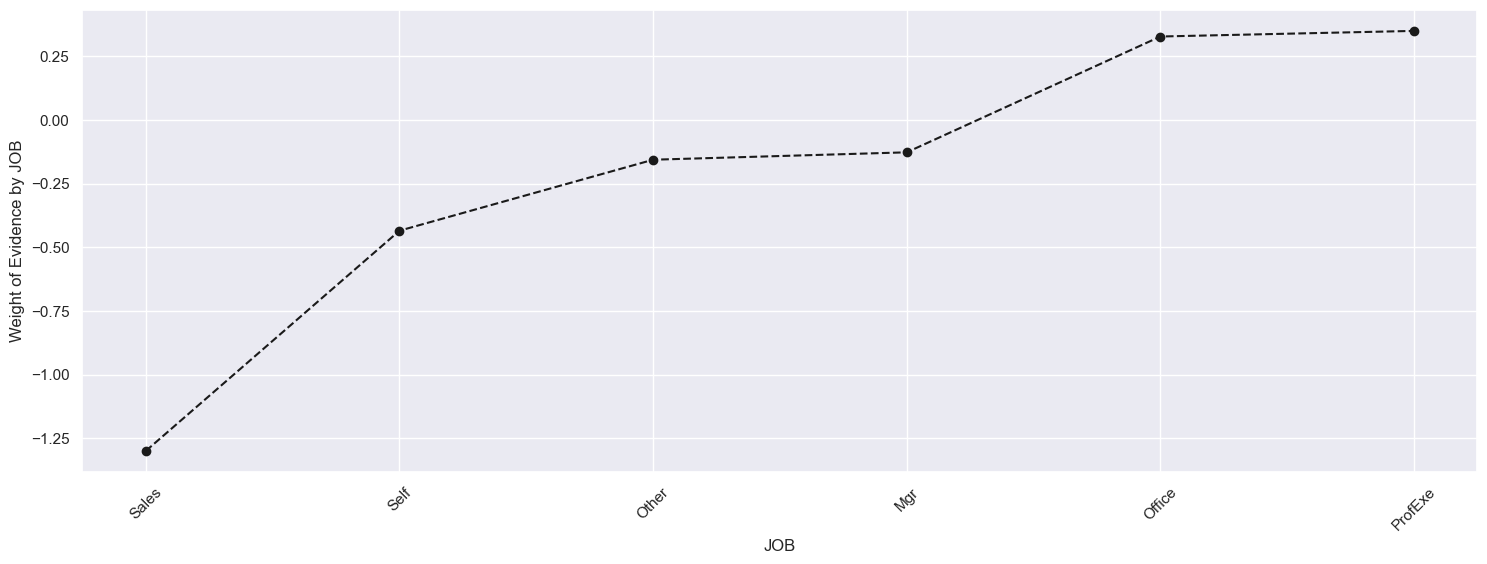

In [1897]:
plot_by_woe(df_job)

#### We will merge categories [ProfExe , Office] and [Mgr , Other] since they have almost equal Woe

In [1898]:
home_equity['JOB'] = np.where(home_equity['JOB'].isin(['ProfExe', 'Office']), 'ProfExe, Office', home_equity['JOB'])
home_equity['JOB'] = np.where(home_equity['JOB'].isin(['Mgr', 'Other']), 'Mgr,Other', home_equity['JOB'])
home_equity['JOB'].unique()                                           

array(['Mgr,Other', 'ProfExe, Office', 'Sales', 'Self'], dtype=object)

In [1899]:
home_equity = pd.concat([home_equity.drop('JOB', axis = 1), 
                         pd.get_dummies(home_equity['JOB'], prefix = 'job', prefix_sep = ':')], axis=1)
home_equity

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,"job:Mgr,Other","job:ProfExe, Office",job:Sales,job:Self
5,0,1700,30548.0,40320.0,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,1,0,0,0
7,0,1800,28502.0,43034.0,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894,1,0,0,0
19,1,2300,102370.0,120953.0,2.0,0.0,0.0,90.992533,0.0,13.0,31.588503,0,1,0,0
25,0,2400,34863.0,47471.0,12.0,0.0,0.0,70.491080,1.0,21.0,38.263601,1,0,0,0
26,1,2400,98449.0,117195.0,4.0,0.0,0.0,93.811775,0.0,13.0,29.681827,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,1,88900,57264.0,90185.0,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347,1,0,0,0
5956,1,89000,54576.0,92937.0,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971,1,0,0,0
5957,1,89200,54045.0,92924.0,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,1,0,0,0
5958,1,89800,50370.0,91861.0,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882,1,0,0,0


# Fine Classing : bining the continuous variables
# Coarse Classification
# Creating dummies

In [1900]:
home_equity = home_equity.copy()

In [1901]:
def plot_cont_cols(df):
    cont_cols = df.select_dtypes(include=['int64', 'float64'], exclude='object').columns.tolist()
    fig, axs = plt.subplots(1, len(cont_cols), figsize=(20, 6))
    for i, col in enumerate(cont_cols):
     axs[i].hist(df[col], bins=12)
     axs[i].set_title(col)

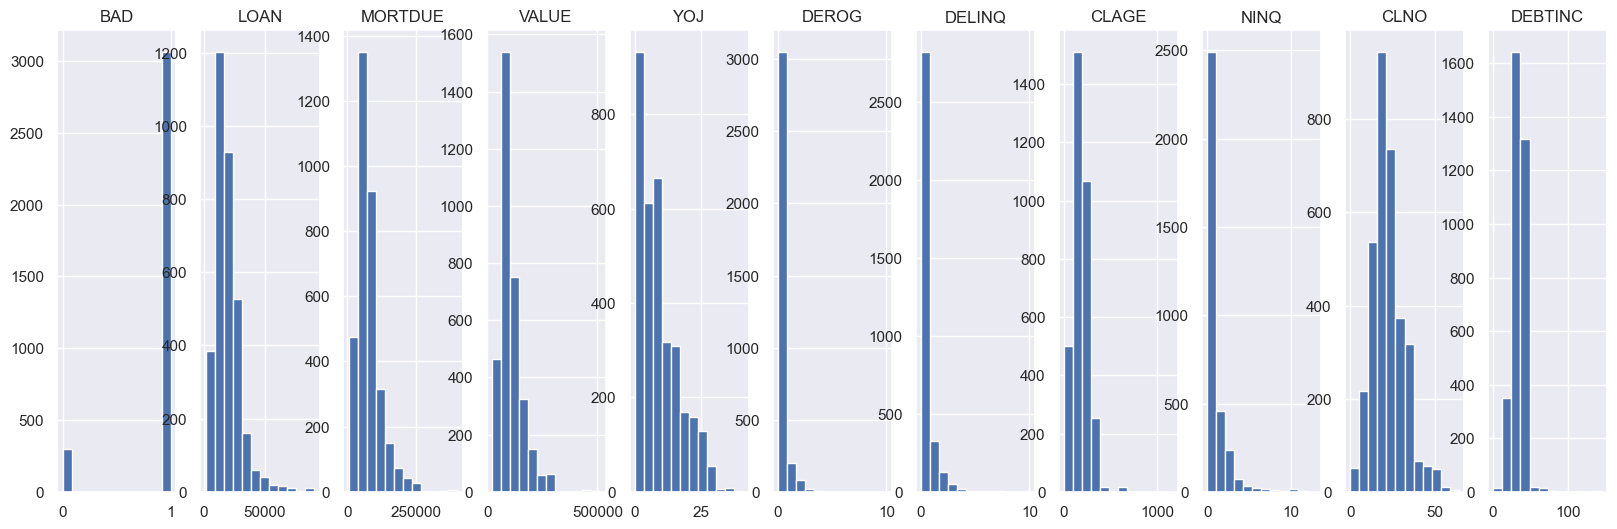

In [1902]:
plot_cont_cols(home_equity)

### We will cut the numerical variables into such number of bins that will produce an optimal IV of the resulting categories

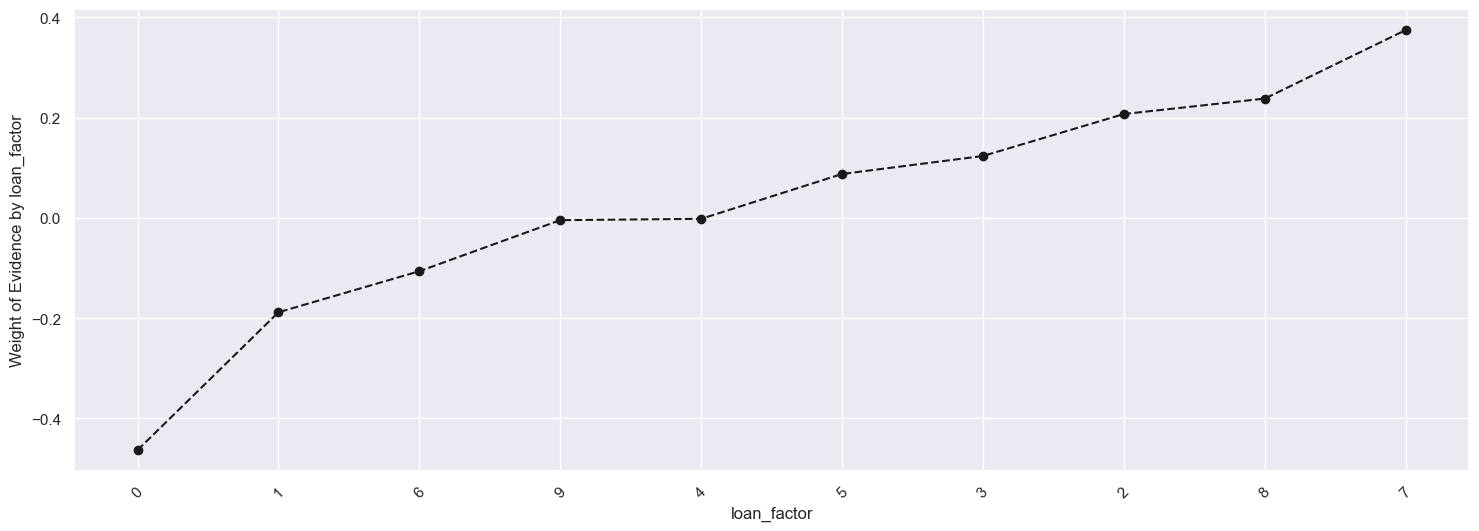

In [1903]:
# qcut() function creates equal-sized bins based on the quantiles of a numerical variable
home_equity['loan_factor'], bins = pd.qcut(home_equity['LOAN'], q=10, retbins=True, labels=False)
df_loan = woe_categorical(home_equity, 'loan_factor', 'BAD')
plot_by_woe(df_loan)

In [1904]:
df_loan

,loan_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,0,349,0.865330,0.103746,302.0,47.0,0.098564,0.156667,-0.463415,0.054989
1,1,350,0.894286,0.104043,313.0,37.0,0.102154,0.123333,-0.188409,0.054989
2,6,336,0.901786,0.099881,303.0,33.0,0.098890,0.110000,-0.106469,0.054989
3,9,335,0.910448,0.099584,305.0,30.0,0.099543,0.100000,-0.004580,0.054989
4,4,347,0.910663,0.103151,316.0,31.0,0.103133,0.103333,-0.001939,0.054989
5,5,328,0.917683,0.097503,301.0,27.0,0.098238,0.090000,0.087579,0.054989
6,3,339,0.920354,0.100773,312.0,27.0,0.101828,0.090000,0.123472,0.054989
7,2,312,0.926282,0.092747,289.0,23.0,0.094321,0.076667,0.207238,0.054989
8,8,335,0.928358,0.099584,311.0,24.0,0.101501,0.080000,0.238045,0.054989
9,7,333,0.936937,0.098989,312.0,21.0,0.101828,0.070000,0.374787,0.054989


In [1905]:
dummies = pd.get_dummies(home_equity['loan_factor'], prefix = 'loan', prefix_sep = ':')

In [1906]:
home_equity = pd.concat([home_equity, dummies], axis=1)

In [1907]:
home_equity = home_equity.drop('loan_factor', axis=1)

In [1908]:
home_equity.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'job:Mgr,Other', 'job:ProfExe, Office',
       'job:Sales', 'job:Self', 'loan:0', 'loan:1', 'loan:2', 'loan:3',
       'loan:4', 'loan:5', 'loan:6', 'loan:7', 'loan:8', 'loan:9'],
      dtype='object')

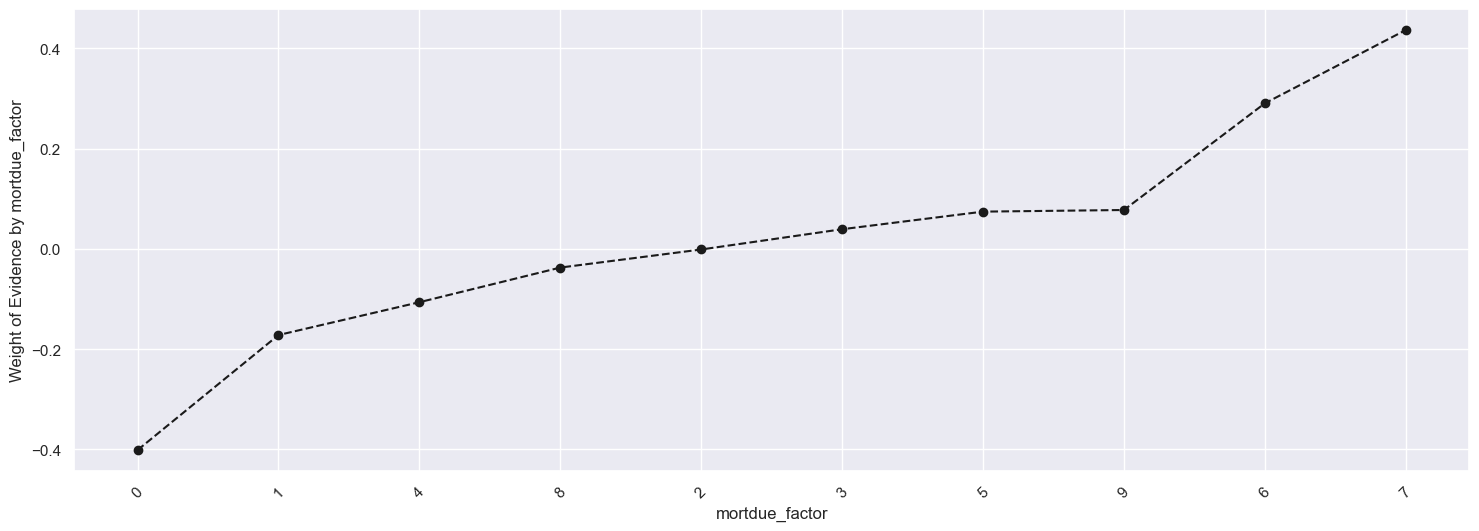

In [1909]:
home_equity['mortdue_factor'], bins = pd.qcut(home_equity['MORTDUE'], q=10, retbins=True, labels=False)
df_mortdue = woe_categorical(home_equity, 'mortdue_factor', 'BAD')
plot_by_woe(df_mortdue)

In [1910]:
df_mortdue

,mortdue_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,0,337,0.872404,0.100178,294.0,43.0,0.095953,0.143333,-0.401314,0.048176
1,1,336,0.895833,0.099881,301.0,35.0,0.098238,0.116667,-0.171932,0.048176
2,4,336,0.901786,0.099881,303.0,33.0,0.098890,0.110000,-0.106469,0.048176
3,8,336,0.907738,0.099881,305.0,31.0,0.099543,0.103333,-0.037369,0.048176
4,2,336,0.910714,0.099881,306.0,30.0,0.099869,0.100000,-0.001306,0.048176
5,3,337,0.913947,0.100178,308.0,29.0,0.100522,0.096667,0.039110,0.048176
6,5,336,0.916667,0.099881,308.0,28.0,0.100522,0.093333,0.074201,0.048176
7,9,337,0.916914,0.100178,309.0,28.0,0.100849,0.093333,0.077443,0.048176
8,6,337,0.931751,0.100178,314.0,23.0,0.102480,0.076667,0.290205,0.048176
9,7,336,0.940476,0.099881,316.0,20.0,0.103133,0.066667,0.436316,0.048176


In [1911]:
dummies = pd.get_dummies(home_equity['mortdue_factor'], prefix = 'mortdue', prefix_sep = ':')
home_equity = pd.concat([home_equity, dummies], axis=1)
home_equity = home_equity.drop('mortdue_factor', axis=1)
home_equity.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'job:Mgr,Other', 'job:ProfExe, Office',
       'job:Sales', 'job:Self', 'loan:0', 'loan:1', 'loan:2', 'loan:3',
       'loan:4', 'loan:5', 'loan:6', 'loan:7', 'loan:8', 'loan:9', 'mortdue:0',
       'mortdue:1', 'mortdue:2', 'mortdue:3', 'mortdue:4', 'mortdue:5',
       'mortdue:6', 'mortdue:7', 'mortdue:8', 'mortdue:9'],
      dtype='object')

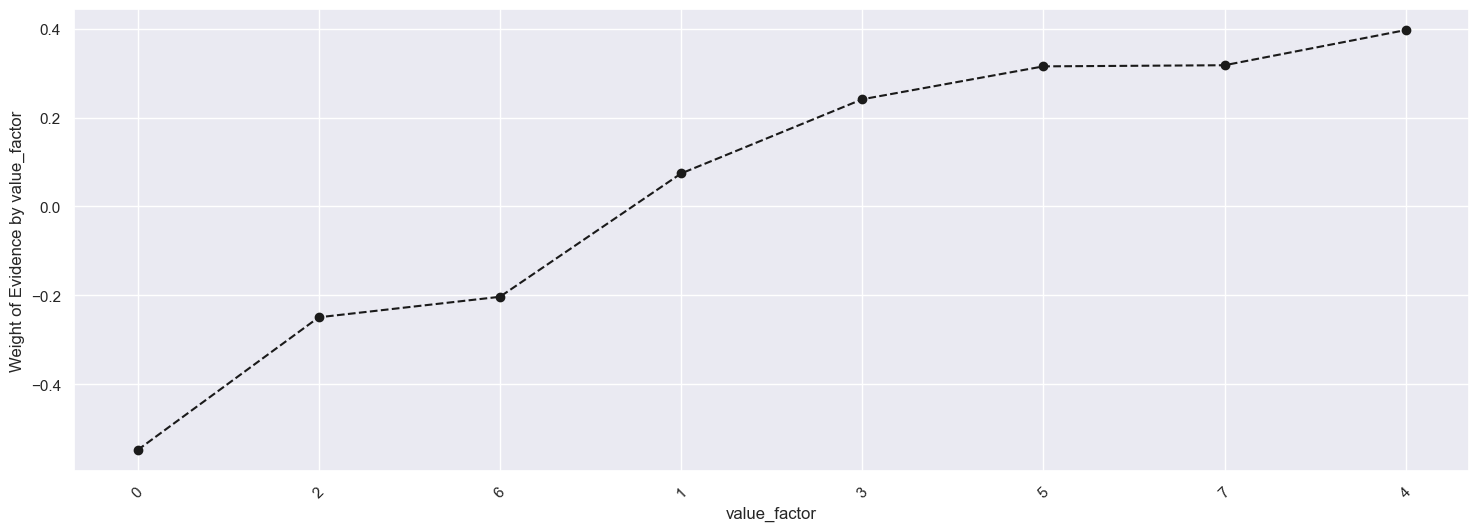

In [1912]:
home_equity['value_factor'], bins = pd.qcut(home_equity['VALUE'], q=8, retbins=True, labels=False)
df_value = woe_categorical(home_equity, 'value_factor', 'BAD')
plot_by_woe(df_value)

In [1913]:
df_value

,value_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,0,421,0.855107,0.125149,360.0,61.0,0.117493,0.203333,-0.548464,0.107378
1,2,421,0.888361,0.125149,374.0,47.0,0.122063,0.156667,-0.249586,0.107378
2,6,420,0.892857,0.124851,375.0,45.0,0.122389,0.150000,-0.203431,0.107378
3,1,420,0.916667,0.124851,385.0,35.0,0.125653,0.116667,0.074201,0.107378
4,3,420,0.928571,0.124851,390.0,30.0,0.127285,0.100000,0.241255,0.107378
5,5,420,0.933333,0.124851,392.0,28.0,0.127937,0.093333,0.315363,0.107378
6,7,421,0.933492,0.125149,393.0,28.0,0.128264,0.093333,0.317911,0.107378
7,4,421,0.938242,0.125149,395.0,26.0,0.128916,0.086667,0.397095,0.107378


In [1914]:
dummies = pd.get_dummies(home_equity['value_factor'], prefix = 'value', prefix_sep = ':')
home_equity = pd.concat([home_equity, dummies], axis=1)
home_equity = home_equity.drop('value_factor', axis=1)
home_equity.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'job:Mgr,Other', 'job:ProfExe, Office',
       'job:Sales', 'job:Self', 'loan:0', 'loan:1', 'loan:2', 'loan:3',
       'loan:4', 'loan:5', 'loan:6', 'loan:7', 'loan:8', 'loan:9', 'mortdue:0',
       'mortdue:1', 'mortdue:2', 'mortdue:3', 'mortdue:4', 'mortdue:5',
       'mortdue:6', 'mortdue:7', 'mortdue:8', 'mortdue:9', 'value:0',
       'value:1', 'value:2', 'value:3', 'value:4', 'value:5', 'value:6',
       'value:7'],
      dtype='object')

In [1915]:
home_equity['yoj_factor'], bins = pd.qcut(home_equity['YOJ'], q=5, retbins=True, labels=False)
df_yoj = woe_categorical(home_equity, 'yoj_factor', 'BAD')
df_yoj

,yoj_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,1,613,0.884176,0.182224,542.0,71.0,0.176893,0.236667,-0.291108,0.10287
1,0,735,0.899320,0.218490,661.0,74.0,0.215731,0.246667,-0.134005,0.10287
2,3,652,0.901840,0.193817,588.0,64.0,0.191906,0.213333,-0.105850,0.10287
3,2,697,0.912482,0.207194,636.0,61.0,0.207572,0.203333,0.020631,0.10287
4,4,667,0.955022,0.198276,637.0,30.0,0.207898,0.100000,0.731878,0.10287


In [1916]:
dummies = pd.get_dummies(home_equity['yoj_factor'], prefix = 'yoj', prefix_sep = ':')
home_equity = pd.concat([home_equity, dummies], axis=1)
home_equity = home_equity.drop('yoj_factor', axis=1)
home_equity.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'job:Mgr,Other', 'job:ProfExe, Office',
       'job:Sales', 'job:Self', 'loan:0', 'loan:1', 'loan:2', 'loan:3',
       'loan:4', 'loan:5', 'loan:6', 'loan:7', 'loan:8', 'loan:9', 'mortdue:0',
       'mortdue:1', 'mortdue:2', 'mortdue:3', 'mortdue:4', 'mortdue:5',
       'mortdue:6', 'mortdue:7', 'mortdue:8', 'mortdue:9', 'value:0',
       'value:1', 'value:2', 'value:3', 'value:4', 'value:5', 'value:6',
       'value:7', 'yoj:0', 'yoj:1', 'yoj:2', 'yoj:3', 'yoj:4'],
      dtype='object')

In [1917]:
home_equity['DEROG'].unique()

array([ 0.,  3.,  2.,  1.,  6.,  5.,  8.,  7., 10.,  9.,  4.])

### Numerical variables that contain limited amount of values we will treat as categorical variables

In [1918]:
df_derog = woe_categorical(home_equity, 'DEROG', 'BAD')
df_derog

C:\Users\Nastya\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,DEROG,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,4.0,3,0.000000,0.000892,0.0,3.0,0.000000,0.010000,-inf,inf
1,5.0,1,0.000000,0.000297,0.0,1.0,0.000000,0.003333,-inf,inf
2,6.0,2,0.000000,0.000595,0.0,2.0,0.000000,0.006667,-inf,inf
3,7.0,2,0.000000,0.000595,0.0,2.0,0.000000,0.006667,-inf,inf
4,8.0,1,0.000000,0.000297,0.0,1.0,0.000000,0.003333,-inf,inf
5,9.0,1,0.000000,0.000297,0.0,1.0,0.000000,0.003333,-inf,inf
6,10.0,1,0.000000,0.000297,0.0,1.0,0.000000,0.003333,-inf,inf
7,3.0,22,0.409091,0.006540,9.0,13.0,0.002937,0.043333,-2.691419,inf
8,2.0,79,0.721519,0.023484,57.0,22.0,0.018603,0.073333,-1.371685,inf
9,1.0,200,0.840000,0.059453,168.0,32.0,0.054830,0.106667,-0.665466,inf


In [1919]:
home_equity['derog:0'] = np.where((home_equity['DEROG'] <= 0) , 1, 0)
home_equity['derog:>0'] = np.where((home_equity['DEROG'] > 0), 1, 0)

In [1920]:
home_equity['DELINQ'].unique()

array([ 0.,  6.,  4.,  3.,  2.,  1.,  8.,  7.,  5., 10.])

In [1921]:
df_delinq = woe_categorical(home_equity, 'DELINQ', 'BAD')
df_delinq

C:\Users\Nastya\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,DELINQ,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,5.0,6,0.000000,0.001784,0.0,6.0,0.000000,0.020000,-inf,inf
1,6.0,7,0.000000,0.002081,0.0,7.0,0.000000,0.023333,-inf,inf
2,7.0,6,0.000000,0.001784,0.0,6.0,0.000000,0.020000,-inf,inf
3,8.0,1,0.000000,0.000297,0.0,1.0,0.000000,0.003333,-inf,inf
4,10.0,1,0.000000,0.000297,0.0,1.0,0.000000,0.003333,-inf,inf
5,4.0,21,0.619048,0.006243,13.0,8.0,0.004243,0.026667,-1.838186,inf
6,2.0,124,0.766129,0.036861,95.0,29.0,0.031005,0.096667,-1.137113,inf
7,3.0,50,0.780000,0.014863,39.0,11.0,0.012728,0.036667,-1.058028,inf
8,1.0,324,0.870370,0.096314,282.0,42.0,0.092037,0.140000,-0.419457,inf
9,0.0,2824,0.933074,0.839477,2635.0,189.0,0.859987,0.630000,0.311197,inf


In [1922]:
home_equity['delinq:0'] = np.where((home_equity['DELINQ'] <= 0) , 1, 0)
home_equity['delinq:1'] = np.where((home_equity['DELINQ'] <= 1), 1, 0)
home_equity['delinq:>1'] = np.where((home_equity['DELINQ'] > 1), 1, 0)

In [1923]:
home_equity['CLAGE'].unique()

array([101.46600191,  88.76602988,  90.99253347, ..., 212.27969667,
       213.89270901, 219.60100218])

In [1924]:
home_equity['clage_factor'], bins = pd.qcut(home_equity['CLAGE'], q=3, retbins=True, labels=False)
df_clage = woe_categorical(home_equity, 'clage_factor', 'BAD')
df_clage

,clage_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,0,1122,0.864528,0.333532,970.0,152.0,0.316580,0.506667,-0.470279,0.183393
1,1,1121,0.919715,0.333234,1031.0,90.0,0.336488,0.300000,0.114781,0.183393
2,2,1121,0.948260,0.333234,1063.0,58.0,0.346932,0.193333,0.584713,0.183393


In [1925]:
dummies = pd.get_dummies(home_equity['clage_factor'], prefix = 'clage', prefix_sep = ':')
home_equity = pd.concat([home_equity, dummies], axis=1)
home_equity = home_equity.drop('clage_factor', axis=1)
home_equity.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'job:Mgr,Other', 'job:ProfExe, Office',
       'job:Sales', 'job:Self', 'loan:0', 'loan:1', 'loan:2', 'loan:3',
       'loan:4', 'loan:5', 'loan:6', 'loan:7', 'loan:8', 'loan:9', 'mortdue:0',
       'mortdue:1', 'mortdue:2', 'mortdue:3', 'mortdue:4', 'mortdue:5',
       'mortdue:6', 'mortdue:7', 'mortdue:8', 'mortdue:9', 'value:0',
       'value:1', 'value:2', 'value:3', 'value:4', 'value:5', 'value:6',
       'value:7', 'yoj:0', 'yoj:1', 'yoj:2', 'yoj:3', 'yoj:4', 'derog:0',
       'derog:>0', 'delinq:0', 'delinq:1', 'delinq:>1', 'clage:0', 'clage:1',
       'clage:2'],
      dtype='object')

In [1926]:
home_equity = home_equity.rename(columns={'clage:0' : 'clage:134 months'})
home_equity = home_equity.rename(columns={'clage:1' : 'clage:208 months'})
home_equity = home_equity.rename(columns={'clage:2' : 'clage:1168 months'})
home_equity.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'job:Mgr,Other', 'job:ProfExe, Office',
       'job:Sales', 'job:Self', 'loan:0', 'loan:1', 'loan:2', 'loan:3',
       'loan:4', 'loan:5', 'loan:6', 'loan:7', 'loan:8', 'loan:9', 'mortdue:0',
       'mortdue:1', 'mortdue:2', 'mortdue:3', 'mortdue:4', 'mortdue:5',
       'mortdue:6', 'mortdue:7', 'mortdue:8', 'mortdue:9', 'value:0',
       'value:1', 'value:2', 'value:3', 'value:4', 'value:5', 'value:6',
       'value:7', 'yoj:0', 'yoj:1', 'yoj:2', 'yoj:3', 'yoj:4', 'derog:0',
       'derog:>0', 'delinq:0', 'delinq:1', 'delinq:>1', 'clage:134 months',
       'clage:208 months', 'clage:1168 months'],
      dtype='object')

In [1927]:
home_equity['NINQ'].unique()

array([ 1.,  0.,  2.,  3., 10.,  9.,  6.,  7.,  8.,  4.,  5., 11., 13.])

In [1928]:
df_ninq = woe_categorical(home_equity, 'NINQ', 'BAD')
df_ninq

C:\Users\Nastya\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,NINQ,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,13.0,1,0.000000,0.000297,0.0,1.0,0.000000,0.003333,-inf,inf
1,7.0,15,0.600000,0.004459,9.0,6.0,0.002937,0.020000,-1.918229,inf
2,6.0,22,0.636364,0.006540,14.0,8.0,0.004569,0.026667,-1.764078,inf
3,5.0,31,0.677419,0.009215,21.0,10.0,0.006854,0.033333,-1.581757,inf
4,9.0,7,0.714286,0.002081,5.0,2.0,0.001632,0.006667,-1.407403,inf
5,8.0,12,0.750000,0.003567,9.0,3.0,0.002937,0.010000,-1.225082,inf
6,4.0,75,0.800000,0.022295,60.0,15.0,0.019582,0.050000,-0.937400,inf
7,10.0,17,0.823529,0.005054,14.0,3.0,0.004569,0.010000,-0.783249,inf
8,3.0,234,0.888889,0.069560,208.0,26.0,0.067885,0.086667,-0.244253,inf
9,2.0,456,0.914474,0.135553,417.0,39.0,0.136097,0.130000,0.045831,inf


In [1929]:
home_equity['ninq:0'] = np.where((home_equity['NINQ'] <= 0) , 1, 0)
home_equity['ninq:1'] = np.where((home_equity['NINQ'] <= 1), 1, 0)
home_equity['ninq:>1'] = np.where((home_equity['NINQ'] > 1), 1, 0)

In [1930]:
home_equity['CLNO'].unique()

array([ 8., 13., 21., 37., 14., 12., 33., 20.,  9., 19., 31., 15.,  5.,
       30., 17., 27., 11., 28., 10.,  6., 36., 22., 24., 23., 26., 25.,
       16.,  7., 32., 18., 47., 46., 38., 29., 35., 42., 34.,  3.,  2.,
       56., 55.,  4.,  1., 51., 43., 45., 39., 49., 48., 50., 40., 41.,
       64.,  0., 63., 44., 58.])

In [1931]:
home_equity['clno_factor'], bins = pd.qcut(home_equity['CLNO'], q=5, retbins=True, labels=False)
df_clno = woe_categorical(home_equity, 'clno_factor', 'BAD')
df_clno

,clno_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,0,691,0.887120,0.205410,613.0,78.0,0.200065,0.260000,-0.262038,0.044573
1,4,657,0.898021,0.195303,590.0,67.0,0.192559,0.223333,-0.148264,0.044573
2,2,625,0.910400,0.185791,569.0,56.0,0.185705,0.186667,-0.005165,0.044573
3,1,742,0.924528,0.220571,686.0,56.0,0.223890,0.186667,0.181832,0.044573
4,3,649,0.933744,0.192925,606.0,43.0,0.197781,0.143333,0.321986,0.044573


In [1932]:
print(bins[1])

14.0


In [1933]:
print(bins[2])

19.0


In [1934]:
print(bins[3])

23.0


In [1935]:
print(bins[4])

29.0


In [1936]:
print(bins[5])

64.0


In [1937]:
dummies = pd.get_dummies(home_equity['clno_factor'], prefix = 'clno', prefix_sep = ':')
home_equity = pd.concat([home_equity, dummies], axis=1)
home_equity = home_equity.drop('clno_factor', axis=1)
home_equity.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'job:Mgr,Other', 'job:ProfExe, Office',
       'job:Sales', 'job:Self', 'loan:0', 'loan:1', 'loan:2', 'loan:3',
       'loan:4', 'loan:5', 'loan:6', 'loan:7', 'loan:8', 'loan:9', 'mortdue:0',
       'mortdue:1', 'mortdue:2', 'mortdue:3', 'mortdue:4', 'mortdue:5',
       'mortdue:6', 'mortdue:7', 'mortdue:8', 'mortdue:9', 'value:0',
       'value:1', 'value:2', 'value:3', 'value:4', 'value:5', 'value:6',
       'value:7', 'yoj:0', 'yoj:1', 'yoj:2', 'yoj:3', 'yoj:4', 'derog:0',
       'derog:>0', 'delinq:0', 'delinq:1', 'delinq:>1', 'clage:134 months',
       'clage:208 months', 'clage:1168 months', 'ninq:0', 'ninq:1', 'ninq:>1',
       'clno:0', 'clno:1', 'clno:2', 'clno:3', 'clno:4'],
      dtype='object')

In [1938]:
home_equity = home_equity.rename(columns={'clno:0' : 'clno:14'})
home_equity = home_equity.rename(columns={'clno:1' : 'clno:19'})
home_equity = home_equity.rename(columns={'clno:2' : 'clno:23'})
home_equity = home_equity.rename(columns={'clno:3' : 'clno:29'})
home_equity = home_equity.rename(columns={'clno:4' : 'clno:64'})
home_equity.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'job:Mgr,Other', 'job:ProfExe, Office',
       'job:Sales', 'job:Self', 'loan:0', 'loan:1', 'loan:2', 'loan:3',
       'loan:4', 'loan:5', 'loan:6', 'loan:7', 'loan:8', 'loan:9', 'mortdue:0',
       'mortdue:1', 'mortdue:2', 'mortdue:3', 'mortdue:4', 'mortdue:5',
       'mortdue:6', 'mortdue:7', 'mortdue:8', 'mortdue:9', 'value:0',
       'value:1', 'value:2', 'value:3', 'value:4', 'value:5', 'value:6',
       'value:7', 'yoj:0', 'yoj:1', 'yoj:2', 'yoj:3', 'yoj:4', 'derog:0',
       'derog:>0', 'delinq:0', 'delinq:1', 'delinq:>1', 'clage:134 months',
       'clage:208 months', 'clage:1168 months', 'ninq:0', 'ninq:1', 'ninq:>1',
       'clno:14', 'clno:19', 'clno:23', 'clno:29', 'clno:64'],
      dtype='object')

In [1939]:
home_equity['debtinc_fac'], bins = pd.qcut(home_equity['DEBTINC'], q=2, retbins=True, labels=False)
df_debtinc = woe_categorical(home_equity, 'debtinc_fac', 'BAD')
df_debtinc

,debtinc_fac,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,1,1682,0.881094,0.5,1482.0,200.0,0.483681,0.666667,-0.320864,0.138784
1,0,1682,0.940547,0.5,1582.0,100.0,0.516319,0.333333,0.437581,0.138784


In [1940]:
bins[1]

35.1294835285

In [1941]:
bins[2]

144.18900129

In [1942]:
dummies = pd.get_dummies(home_equity['debtinc_fac'], prefix = 'debtinc', prefix_sep = ':')
home_equity = pd.concat([home_equity, dummies], axis=1)
home_equity = home_equity.drop('debtinc_fac', axis=1)
home_equity.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'job:Mgr,Other', 'job:ProfExe, Office',
       'job:Sales', 'job:Self', 'loan:0', 'loan:1', 'loan:2', 'loan:3',
       'loan:4', 'loan:5', 'loan:6', 'loan:7', 'loan:8', 'loan:9', 'mortdue:0',
       'mortdue:1', 'mortdue:2', 'mortdue:3', 'mortdue:4', 'mortdue:5',
       'mortdue:6', 'mortdue:7', 'mortdue:8', 'mortdue:9', 'value:0',
       'value:1', 'value:2', 'value:3', 'value:4', 'value:5', 'value:6',
       'value:7', 'yoj:0', 'yoj:1', 'yoj:2', 'yoj:3', 'yoj:4', 'derog:0',
       'derog:>0', 'delinq:0', 'delinq:1', 'delinq:>1', 'clage:134 months',
       'clage:208 months', 'clage:1168 months', 'ninq:0', 'ninq:1', 'ninq:>1',
       'clno:14', 'clno:19', 'clno:23', 'clno:29', 'clno:64', 'debtinc:0',
       'debtinc:1'],
      dtype='object')

In [1943]:
home_equity = home_equity.rename(columns={'debtinc:0' : 'debtinc:35'})
home_equity = home_equity.rename(columns={'debtinc:1' : 'debtinc:144'})
home_equity.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'job:Mgr,Other', 'job:ProfExe, Office',
       'job:Sales', 'job:Self', 'loan:0', 'loan:1', 'loan:2', 'loan:3',
       'loan:4', 'loan:5', 'loan:6', 'loan:7', 'loan:8', 'loan:9', 'mortdue:0',
       'mortdue:1', 'mortdue:2', 'mortdue:3', 'mortdue:4', 'mortdue:5',
       'mortdue:6', 'mortdue:7', 'mortdue:8', 'mortdue:9', 'value:0',
       'value:1', 'value:2', 'value:3', 'value:4', 'value:5', 'value:6',
       'value:7', 'yoj:0', 'yoj:1', 'yoj:2', 'yoj:3', 'yoj:4', 'derog:0',
       'derog:>0', 'delinq:0', 'delinq:1', 'delinq:>1', 'clage:134 months',
       'clage:208 months', 'clage:1168 months', 'ninq:0', 'ninq:1', 'ninq:>1',
       'clno:14', 'clno:19', 'clno:23', 'clno:29', 'clno:64', 'debtinc:35',
       'debtinc:144'],
      dtype='object')

# Correlation analysis

In [1944]:
corr_matrix = home_equity.iloc[:, 0:11].corr()
corr_matrix

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
BAD,1.000000,0.031215,0.016552,0.026215,0.064279,-0.253711,-0.274893,0.113906,-0.125714,-0.007529,-0.216959
LOAN,0.031215,1.000000,0.272924,0.378724,0.076359,-0.024263,-0.067468,0.066484,0.051264,0.075893,0.157379
MORTDUE,0.016552,0.272924,1.000000,0.865265,-0.103307,-0.042590,-0.035903,0.137741,0.036424,0.320759,0.185446
VALUE,0.026215,0.378724,0.865265,1.000000,-0.021113,-0.045910,-0.068415,0.197697,-0.006878,0.215466,0.130928
YOJ,0.064279,0.076359,-0.103307,-0.021113,1.000000,-0.055824,0.021976,0.230511,-0.045865,-0.001290,-0.051864
DEROG,-0.253711,-0.024263,-0.042590,-0.045910,-0.055824,1.000000,0.147825,-0.053741,0.181596,0.065897,0.035200
DELINQ,-0.274893,-0.067468,-0.035903,-0.068415,0.021976,0.147825,1.000000,0.011583,0.003523,0.122612,0.038251
CLAGE,0.113906,0.066484,0.137741,0.197697,0.230511,-0.053741,0.011583,1.000000,-0.089076,0.201759,-0.050553
NINQ,-0.125714,0.051264,0.036424,-0.006878,-0.045865,0.181596,0.003523,-0.089076,1.000000,0.077538,0.157328
CLNO,-0.007529,0.075893,0.320759,0.215466,-0.001290,0.065897,0.122612,0.201759,0.077538,1.000000,0.143613


In [1945]:
corr_matrix_with_dummies = home_equity.corr()
corr_matrix_with_dummies

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,ninq:0,ninq:1,ninq:>1,clno:14,clno:19,clno:23,clno:29,clno:64,debtinc:35,debtinc:144
BAD,1.000000,0.031215,0.016552,0.026215,0.064279,-0.253711,-0.274893,0.113906,-0.125714,-0.007529,...,0.039861,0.083868,-0.083868,-0.042281,0.025586,-0.000705,0.039326,-0.022124,0.104303,-0.104303
LOAN,0.031215,1.000000,0.272924,0.378724,0.076359,-0.024263,-0.067468,0.066484,0.051264,0.075893,...,-0.043203,-0.065235,0.065235,-0.087791,-0.003901,-0.036641,0.075959,0.053889,-0.151227,0.151227
MORTDUE,0.016552,0.272924,1.000000,0.865265,-0.103307,-0.042590,-0.035903,0.137741,0.036424,0.320759,...,-0.055953,-0.074643,0.074643,-0.241612,-0.041434,-0.018234,0.124042,0.183983,-0.152597,0.152597
VALUE,0.026215,0.378724,0.865265,1.000000,-0.021113,-0.045910,-0.068415,0.197697,-0.006878,0.215466,...,-0.006152,-0.016055,0.016055,-0.202829,-0.030704,-0.007228,0.141750,0.104812,-0.112471,0.112471
YOJ,0.064279,0.076359,-0.103307,-0.021113,1.000000,-0.055824,0.021976,0.230511,-0.045865,-0.001290,...,0.048109,0.081380,-0.081380,-0.033442,0.003508,0.046497,0.040410,-0.055429,0.000587,-0.000587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
clno:23,-0.000705,-0.036641,-0.018234,-0.007228,0.046497,0.014799,-0.023860,-0.046862,-0.035222,-0.031379,...,0.067807,0.088969,-0.088969,-0.242875,-0.254115,1.000000,-0.233551,-0.235333,-0.029808,0.029808
clno:29,0.039326,0.075959,0.124042,0.141750,0.040410,0.037307,0.041911,0.058701,0.049925,0.199848,...,-0.082222,-0.094157,0.094157,-0.248586,-0.260090,-0.233551,1.000000,-0.240866,0.012807,-0.012807
clno:64,-0.022124,0.053889,0.183983,0.104812,-0.055429,0.007144,0.092450,0.138993,0.039387,0.760719,...,-0.081805,-0.069638,0.069638,-0.250483,-0.262074,-0.235333,-0.240866,1.000000,-0.123725,0.123725
debtinc:35,0.104303,-0.151227,-0.152597,-0.112471,0.000587,-0.004104,-0.031581,-0.001454,-0.132370,-0.116424,...,0.152202,0.131604,-0.131604,0.080203,0.055921,-0.029808,0.012807,-0.123725,1.000000,-1.000000


In [1946]:
drop_columns = [col for col in corr_matrix_with_dummies.columns if any(corr_matrix_with_dummies.loc[:, col] > 0.5)]

# Train and test split

In [1947]:
home_equity = home_equity.drop(['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'], 
                               axis=1)

In [1948]:
x = home_equity.drop('BAD', axis=1) 
y = home_equity['BAD']

In [1949]:
x.shape

(3364, 55)

In [1950]:
y.shape

(3364,)

In [1951]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Build Logistic model

In [1952]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [1953]:
model = LogisticRegression(class_weight='balanced')

In [1954]:
model.fit(x_train, y_train)

LogisticRegression(class_weight='balanced')

In [1955]:
model.intercept_

array([-1.5385105])

In [1956]:
model.coef_

array([[ 0.28087851,  0.61207926, -0.77248393, -0.12033027, -0.50670041,
        -0.16640923, -0.00178807,  0.12339342,  0.10858026,  0.11662057,
        -0.24781855,  0.12902547,  0.35903203,  0.08620808, -0.40864354,
        -0.15484173,  0.22335738,  0.33027434,  0.18212316,  0.45503466,
        -0.00743328,  0.41626749, -0.39426864, -0.64172626, -0.31257241,
        -0.07874514, -0.16933789,  0.01828262,  0.47451387, -0.07674703,
        -0.18192129,  0.32667085, -0.16026867, -0.47796114,  0.10485341,
        -0.22149097,  0.75501094,  0.61420696, -0.61406338,  0.95677114,
         0.52425395, -0.52411037, -0.5629451 , -0.00249373,  0.5655824 ,
        -0.36982777,  0.30337601, -0.30323244, -0.20773829,  0.07113088,
        -0.08518497,  0.39975743, -0.17782147,  0.40615978, -0.40601621]])

In [1957]:
category = x_train.columns.values

In [1958]:
summary_table = pd.DataFrame(columns = ['Category'], data=category)
summary_table['Coefficients'] = np.transpose(model.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', model.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table.head()

,Category,Coefficients
0,Intercept,-1.538511
1,"job:Mgr,Other",0.280879
2,"job:ProfExe, Office",0.612079
3,job:Sales,-0.772484
4,job:Self,-0.120330


### Calculate the predicted probabilities

In [1959]:
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.
y_pred_test = model.predict(x_test)

In [1960]:
# Calculates the predicted probability values for the dependent variable (targets)
# 1st element of array is probability of default or the probability of being a bad borrower
# 2nd element is the probability of being a good borrower: 1 - PD
y_pred_test_probabilities = model.predict_proba(x_test)
y_pred_test_probabilities

array([[0.66070151, 0.33929849],
       [0.02563873, 0.97436127],
       [0.86927465, 0.13072535],
       ...,
       [0.18875058, 0.81124942],
       [0.76867202, 0.23132798],
       [0.72402922, 0.27597078]])

In [1961]:
# we take only the probabilities for being 0, eg. being Good
y_pred_test_probs = y_pred_test_probabilities[: ][: , 1]
y_pred_test_probs

array([0.33929849, 0.97436127, 0.13072535, 0.49210159, 0.20142246,
       0.71788567, 0.69778243, 0.65139275, 0.87854655, 0.61852673,
       0.86148294, 0.17200555, 0.73866317, 0.65510196, 0.79364639,
       0.91275323, 0.9822685 , 0.35550509, 0.25677645, 0.84234011,
       0.52761881, 0.84932759, 0.38395395, 0.5484554 , 0.63977138,
       0.65641598, 0.69953553, 0.44679338, 0.2020233 , 0.90235217,
       0.60577945, 0.0781486 , 0.49710875, 0.8002013 , 0.47842729,
       0.82169165, 0.52846762, 0.71998142, 0.35833107, 0.5765707 ,
       0.72045475, 0.73158683, 0.68502067, 0.68196987, 0.6306057 ,
       0.78909174, 0.54747615, 0.93603256, 0.22677932, 0.20203999,
       0.56155676, 0.88690941, 0.84589063, 0.37245445, 0.92784371,
       0.8829754 , 0.55009362, 0.42753304, 0.69432152, 0.73060251,
       0.47575724, 0.93087204, 0.69769938, 0.64847154, 0.68364997,
       0.89781662, 0.08892526, 0.84538259, 0.5577315 , 0.78508059,
       0.81712064, 0.70350352, 0.91830555, 0.86679349, 0.72548

In [1962]:
y_test.shape

(673,)

In [1963]:
y_pred_test_probs.shape

(673,)

# AR and AUC

In [1964]:
# We will use thhe deafult value of a cutoof for the purposes of research
cutoff = 0.5

In [1965]:
from sklearn.metrics import confusion_matrix

In [1966]:
conf_matrix = confusion_matrix(y_test, y_pred_test)

print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[ 37  19]
 [160 457]]


The weight of Type 2 Error is quite large: too many bad applicants are approved, eg. false negative 

In [1967]:
TP = conf_matrix[1,1]
TN = conf_matrix[0,0]
FP = conf_matrix[0,1]
FN = conf_matrix[1,0]

accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy ratio:", accuracy)

Accuracy ratio: 0.7340267459138187


In [1968]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [1969]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_probs)

Text(0.5, 1.0, 'ROC curve')

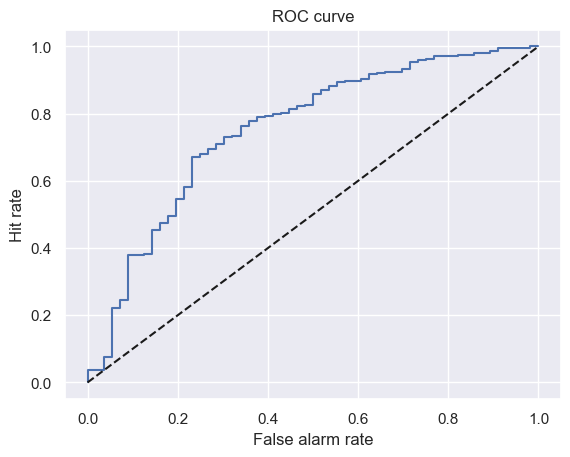

In [1970]:
sns.set()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False alarm rate')
plt.ylabel('Hit rate')
plt.title('ROC curve')

In [1971]:
auc = roc_auc_score(y_test, y_pred_test_probs)
print(auc)

0.7537045612410281


#### Resulting AUC score is quite optimistic. It is quite near to 1 which indicates good model performance 

In [1972]:
gini = 2*auc - 1
print(gini)

0.5074091224820563


#### Gini coefficient  is quite high as well, which indicates high inequality of distribution, which means that model discriminates well between good and bad borrowers

# Creating scorecard

In [1973]:
summary_table

,Category,Coefficients
0,Intercept,-1.538511
1,"job:Mgr,Other",0.280879
2,"job:ProfExe, Office",0.612079
3,job:Sales,-0.772484
4,job:Self,-0.120330
5,loan:0,-0.506700
6,loan:1,-0.166409
7,loan:2,-0.001788
8,loan:3,0.123393
9,loan:4,0.108580


#### We need to turn the regression coefficients into scores. Higher coefficients correspond to being a better borrower. So the higher the coefficients, the better crediworthiness of a borrower. The lower the coefficient, the worse a crediworthiness
#### The maximum creditwotiness is achieved when a borrower falls into categories with highest coeffcients

In [1974]:
min_score = 300          # we will use FICO scores as a baseline
max_score = 850          # scores in the 670 to 739 range considered to be “good” credit scores

In [1975]:
df_scorecard = summary_table
df_scorecard['Category name'] = df_scorecard['Category'].str.split(':').str[0]
df_scorecard

,Category,Coefficients,Category name
0,Intercept,-1.538511,Intercept
1,"job:Mgr,Other",0.280879,job
2,"job:ProfExe, Office",0.612079,job
3,job:Sales,-0.772484,job
4,job:Self,-0.120330,job
5,loan:0,-0.506700,loan
6,loan:1,-0.166409,loan
7,loan:2,-0.001788,loan
8,loan:3,0.123393,loan
9,loan:4,0.108580,loan


In [1976]:
df_scorecard.groupby('Category name')['Coefficients'].min()

Category name
Intercept   -1.538511
clage       -0.562945
clno        -0.207738
debtinc     -0.406016
delinq      -0.524110
derog       -0.614063
job         -0.772484
loan        -0.506700
mortdue     -0.641726
ninq        -0.369828
value       -0.312572
yoj         -0.477961
Name: Coefficients, dtype: float64

In [1977]:
min_sum_coef = df_scorecard.groupby('Category name')['Coefficients'].min().sum()
min_sum_coef

-6.934655766317977

In [1978]:
df_scorecard.groupby('Category name')['Coefficients'].max()

Category name
Intercept   -1.538511
clage        0.565582
clno         0.399757
debtinc      0.406160
delinq       0.956771
derog        0.614207
job          0.612079
loan         0.359032
mortdue      0.455035
ninq         0.303376
value        0.474514
yoj          0.755011
Name: Coefficients, dtype: float64

In [1979]:
max_sum_coef = df_scorecard.groupby('Category name')['Coefficients'].max().sum()
max_sum_coef

4.363013983044732

#### Rescale coefficients to scores: 
#### Variable score = variable_coef * ((max_score - min_score) / (max_sum_coef - min_sum_coef))

In [1980]:
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
df_scorecard.head()

,Category,Coefficients,Category name,Score - Calculation
0,Intercept,-1.538511,Intercept,-74.898700
1,"job:Mgr,Other",0.280879,job,13.673898
2,"job:ProfExe, Office",0.612079,job,29.797613
3,job:Sales,-0.772484,job,-37.606530
4,job:Self,-0.120330,job,-5.857991


In [1981]:
# A positive score of the intercept in a logistic regression model means that 
# when all other predictor variables are equal to zero, the probability of the positive outcome 
# (i.e., the outcome of interest) is greater than 0.5.  
# positive intercept indicates a higher baseline probability of the positive outcome 
# while a negative intercept indicates a lower baseline probability

In [1982]:
# intercept score calculation
df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] - 
                                           min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
df_scorecard.head()

C:\Users\Nastya\AppData\Local\Temp\ipykernel_20052\3717988425.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] -


,Category,Coefficients,Category name,Score - Calculation
0,Intercept,-1.538511,Intercept,562.698411
1,"job:Mgr,Other",0.280879,job,13.673898
2,"job:ProfExe, Office",0.612079,job,29.797613
3,job:Sales,-0.772484,job,-37.606530
4,job:Self,-0.120330,job,-5.857991


In [1983]:
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard.head()

,Category,Coefficients,Category name,Score - Calculation,Score - Preliminary
0,Intercept,-1.538511,Intercept,562.698411,563.0
1,"job:Mgr,Other",0.280879,job,13.673898,14.0
2,"job:ProfExe, Office",0.612079,job,29.797613,30.0
3,job:Sales,-0.772484,job,-37.606530,-38.0
4,job:Self,-0.120330,job,-5.857991,-6.0


In [1984]:
min_sum_score_prel = df_scorecard.groupby('Category name')['Score - Preliminary'].min().sum()
min_sum_score_prel

300.0

In [1985]:
max_sum_score_prel = df_scorecard.groupby('Category name')['Score - Preliminary'].max().sum()
max_sum_score_prel

851.0

#### the value is greater than upper threshold due to the rounding

In [1986]:
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard

,Category,Coefficients,Category name,Score - Calculation,Score - Preliminary,Difference
0,Intercept,-1.538511,Intercept,562.698411,563.0,0.301589
1,"job:Mgr,Other",0.280879,job,13.673898,14.0,0.326102
2,"job:ProfExe, Office",0.612079,job,29.797613,30.0,0.202387
3,job:Sales,-0.772484,job,-37.606530,-38.0,-0.393470
4,job:Self,-0.120330,job,-5.857991,-6.0,-0.142009
5,loan:0,-0.506700,loan,-24.667496,-25.0,-0.332504
6,loan:1,-0.166409,loan,-8.101235,-8.0,0.101235
7,loan:2,-0.001788,loan,-0.087048,-0.0,0.087048
8,loan:3,0.123393,loan,6.007113,6.0,-0.007113
9,loan:4,0.108580,loan,5.285970,5.0,-0.285970


In [1987]:
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard['Score - Final'][45] = 27

C:\Users\Nastya\AppData\Local\Temp\ipykernel_20052\2705269442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scorecard['Score - Final'][45] = 27


In [1988]:
min_sum_score_prel = df_scorecard.groupby('Category name')['Score - Final'].min().sum()
min_sum_score_prel

300.0

In [1989]:
max_sum_score_prel = df_scorecard.groupby('Category name')['Score - Final'].max().sum()
max_sum_score_prel

850.0

## Calculate the credit score

In [1990]:
x_test.head()

,"job:Mgr,Other","job:ProfExe, Office",job:Sales,job:Self,loan:0,loan:1,loan:2,loan:3,loan:4,loan:5,...,ninq:0,ninq:1,ninq:>1,clno:14,clno:19,clno:23,clno:29,clno:64,debtinc:35,debtinc:144
2151,1,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,1
4264,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,1,0
1649,0,1,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,0,1,0,1
5137,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
563,1,0,0,0,1,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,1


In [1991]:
df_scorecard.head()

,Category,Coefficients,Category name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,Intercept,-1.538511,Intercept,562.698411,563.0,0.301589,563.0
1,"job:Mgr,Other",0.280879,job,13.673898,14.0,0.326102,14.0
2,"job:ProfExe, Office",0.612079,job,29.797613,30.0,0.202387,30.0
3,job:Sales,-0.772484,job,-37.606530,-38.0,-0.393470,-38.0
4,job:Self,-0.120330,job,-5.857991,-6.0,-0.142009,-6.0


In [1992]:
# add the intercept to the test data
x_test_with_itercept = x_test

In [1993]:
x_test_with_itercept.insert(0, "Intercept", 1)

In [1994]:
#arrange columns in the same order as the scorecard df
x_test_with_itercept = x_test_with_itercept[df_scorecard['Category'].values]
x_test_with_itercept.head()

,Intercept,"job:Mgr,Other","job:ProfExe, Office",job:Sales,job:Self,loan:0,loan:1,loan:2,loan:3,loan:4,...,ninq:0,ninq:1,ninq:>1,clno:14,clno:19,clno:23,clno:29,clno:64,debtinc:35,debtinc:144
2151,1,1,0,0,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,1
4264,1,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,1,0
1649,1,0,1,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,1,0,1
5137,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
563,1,1,0,0,0,1,0,0,0,0,...,1,1,0,1,0,0,0,0,0,1


In [1995]:
scores = df_scorecard['Score - Final']

In [1996]:
x_test_with_itercept.shape

(673, 56)

In [1997]:
scores = scores.values.reshape(56, 1)
scores.shape

(56, 1)

In [1998]:
#multiply each row from the test data by the column with scores and sum the products
test_scores = x_test_with_itercept.dot(scores)
test_scores.columns = ['score']
test_scores.head()

,score
2151,607.0
4264,816.0
1649,545.0
5137,637.0
563,573.0


In [1999]:
test_scores.shape

(673, 1)

### Setting cutoff

In [2000]:
thresholds.shape

(175,)

In [2001]:
df_cutoffs = pd.concat([pd.DataFrame(thresholds), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis=1)
df_cutoffs.columns = ['thresholds', 'fpr', 'tpr']
df_cutoffs.head()

,thresholds,fpr,tpr
0,1.987683,0.000000,0.000000
1,0.987683,0.000000,0.001621
2,0.928522,0.000000,0.037277
3,0.928087,0.035714,0.037277
4,0.915605,0.035714,0.059968


In [2002]:
df_cutoffs['thresholds'][0] = 0.999999

In [2003]:
# covert the probability of being good to the score and assign to corresponding threshold
df_cutoffs['score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * 
                       ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()

In [2004]:
df_cutoffs.head()

,thresholds,fpr,tpr,score
0,0.999999,0.000000,0.000000,1310.0
1,0.987683,0.000000,0.001621,851.0
2,0.928522,0.000000,0.037277,762.0
3,0.928087,0.035714,0.037277,762.0
4,0.915605,0.035714,0.059968,754.0


In [2005]:
df_cutoffs.tail()

,thresholds,fpr,tpr,score
170,0.084565,0.928571,0.995138,522.0
171,0.079597,0.928571,0.996759,518.0
172,0.048736,0.982143,0.996759,493.0
173,0.040462,0.982143,1.000000,483.0
174,0.029203,1.000000,1.000000,467.0


In [2006]:
# a function assigns a value of 1 if a predicted probability
# is greater than the  threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus the function will return
# the number of rows with estimated probabilites greater than the threshold. 
def n_approved(tr):
    return np.where(y_pred_test_probs >= tr, 1, 0).sum()

In [2007]:
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
df_cutoffs['N Rejected'] = y_pred_test_probs.shape[0] - df_cutoffs['N Approved']
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_pred_test_probs.shape[0]
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
df_cutoffs.head()

,thresholds,fpr,tpr,score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,0.999999,0.000000,0.000000,1310.0,0,673,0.000000,1.000000
1,0.987683,0.000000,0.001621,851.0,1,672,0.001486,0.998514
2,0.928522,0.000000,0.037277,762.0,23,650,0.034175,0.965825
3,0.928087,0.035714,0.037277,762.0,25,648,0.037147,0.962853
4,0.915605,0.035714,0.059968,754.0,39,634,0.057949,0.942051


In [2008]:
df_cutoffs.tail()

,thresholds,fpr,tpr,score,N Approved,N Rejected,Approval Rate,Rejection Rate
170,0.084565,0.928571,0.995138,522.0,666,7,0.989599,0.010401
171,0.079597,0.928571,0.996759,518.0,667,6,0.991085,0.008915
172,0.048736,0.982143,0.996759,493.0,670,3,0.995542,0.004458
173,0.040462,0.982143,1.000000,483.0,672,1,0.998514,0.001486
174,0.029203,1.000000,1.000000,467.0,673,0,1.000000,0.000000


#### A cutoff set to 0.5 will lead 340 approved applicants and 333 rejected applicant

In [2009]:
print(df_cutoffs.iloc[65])

thresholds          0.654034
fpr                 0.196429
tpr                 0.533225
score             669.000000
N Approved        340.000000
N Rejected        333.000000
Approval Rate       0.505201
Rejection Rate      0.494799
Name: 65, dtype: float64


In [2010]:
x_test_with_itercept.to_csv("x_test_with_itercept")
df_scorecard.to_csv('scorecard')